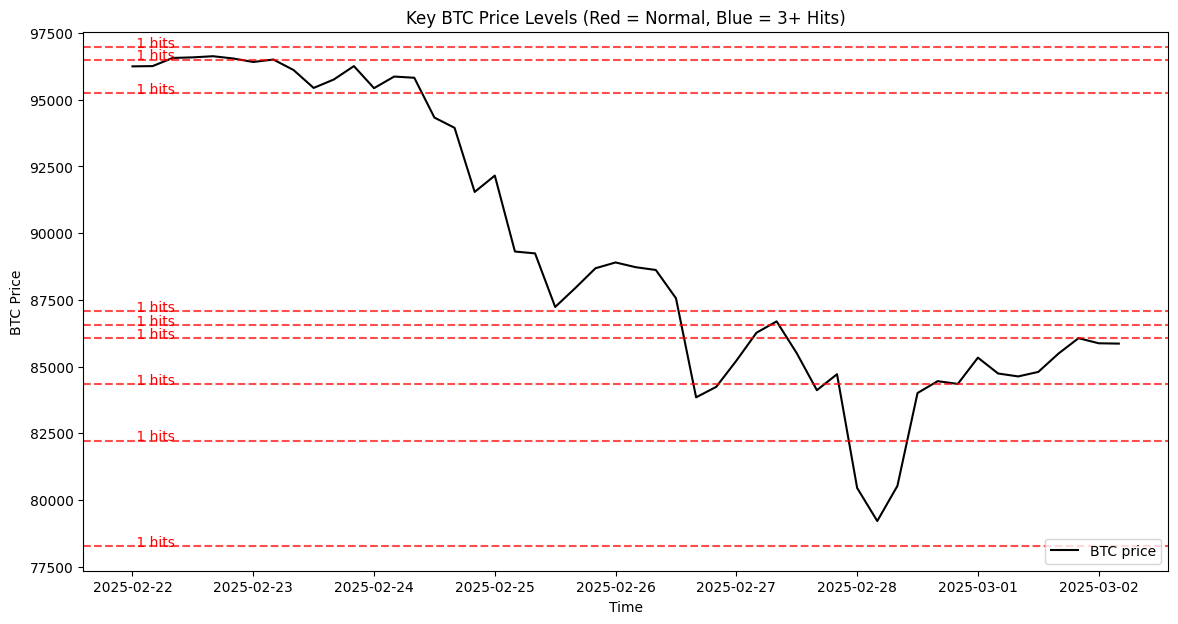

🔹 سطوح کلیدی شناسایی‌شده:
🔴 78264.29 → 1 بار برخورد
🔴 82222.87 → 1 بار برخورد
🔴 84331.88 → 1 بار برخورد
🔴 86055.35 → 1 بار برخورد
🔴 86558.17 → 1 بار برخورد
🔴 87071.12 → 1 بار برخورد
🔴 95243.93 → 1 بار برخورد
🔴 96499.66 → 1 بار برخورد
🔴 96971.63 → 1 بار برخورد


In [4]:
from pybit.unified_trading import HTTP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from finta import TA

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval=240,  # تایم‌فریم 4 ساعته
    limit=50,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['EMA_50'] = TA.EMA(df, 50)
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

# پیدا کردن سطوح کلیدی (بررسی تمام مقادیر: Open, High, Low, Close)
def find_key_levels(df, sensitivity=0.001):
    levels = []
    hits_count = Counter()

    for i in range(2, len(df) - 2):
        prices = [df['open'][i], df['high'][i], df['low'][i], df['close'][i]]

        for price in prices:
            # بررسی سقف (High) و قیمت‌های دیگر
            if (df['high'][i-2] < price and df['high'][i-1] < price and 
                df['high'][i+1] < price and df['high'][i+2] < price):
                levels.append(price)
                hits_count[price] += 1

            # بررسی کف (Low) و قیمت‌های دیگر
            if (df['low'][i-2] > price and df['low'][i-1] > price and 
                df['low'][i+1] > price and df['low'][i+2] > price):
                levels.append(price)
                hits_count[price] += 1

    # فیلتر کردن سطوح نزدیک به هم
    final_levels = {}
    for level in sorted(levels):
        if not final_levels or abs(list(final_levels.keys())[-1] - level) > sensitivity * level:
            final_levels[level] = hits_count[level]

    return final_levels

key_levels = find_key_levels(df)

# رسم نمودار قیمت و نمایش سطوح کلیدی
plt.figure(figsize=(14, 7))
plt.plot(df['timestamp'], df['close'], label="BTC price", color='black')

# رسم خطوط افقی برای سطوح کلیدی
for level, count in key_levels.items():
    color = "red" if count < 3 else "blue"  # سطوح با ۳ برخورد یا بیشتر آبی می‌شوند
    plt.axhline(y=level, linestyle="--", color=color, alpha=0.7)
    plt.text(df['timestamp'].iloc[-1], level, f" {count} hits", color=color, fontsize=10)

plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.title("Key BTC Price Levels (Red = Normal, Blue = 3+ Hits)")
plt.legend()
plt.show()

# نمایش قیمت‌های مهم در کنسول
print("🔹 سطوح کلیدی شناسایی‌شده:")
for level, count in key_levels.items():
    color_tag = "🔵" if count >= 3 else "🔴"
    print(f"{color_tag} {level:.2f} → {count} بار برخورد")


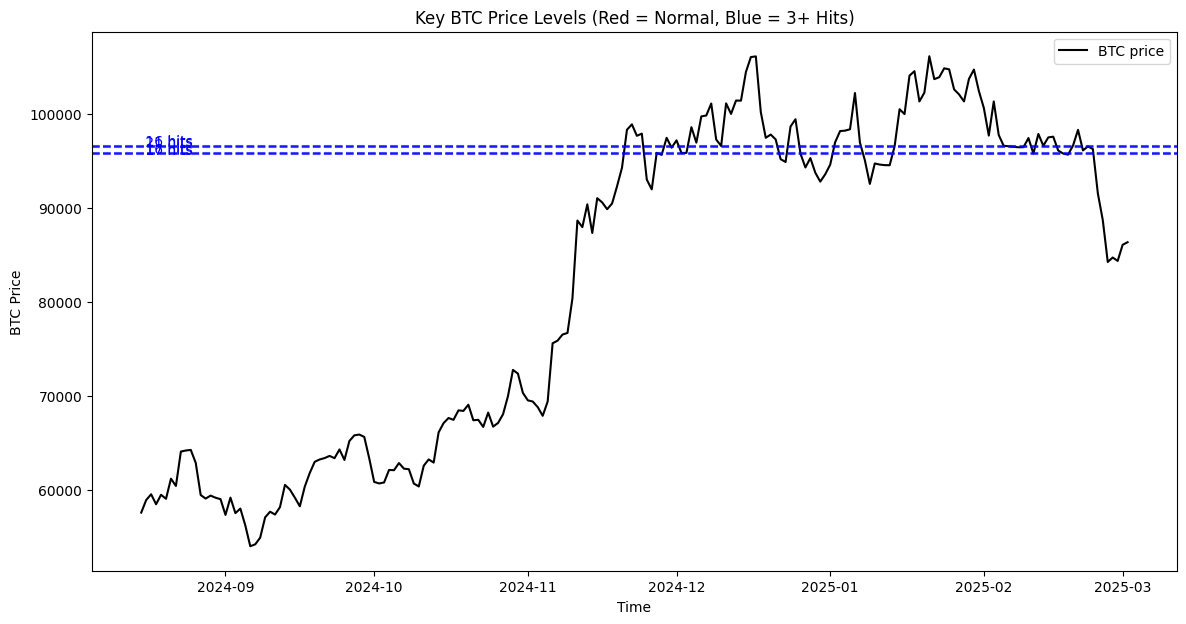

🔹 سطوح کلیدی شناسایی‌شده:
🔵 95689.08 → 17 بار برخورد
🔵 95828.20 → 16 بار برخورد
🔵 96499.66 → 21 بار برخورد
🔵 96638.45 → 16 بار برخورد


In [25]:
from pybit.unified_trading import HTTP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from finta import TA

# اتصال به Bybit (در حالت تست‌نت)
url = HTTP(testnet=True)
response = url.get_index_price_kline(
    category="linear",
    symbol="BTCUSDT",
    interval='D',  # تایم‌فریم 4 ساعته
    limit=200,
)

# تبدیل داده به DataFrame
if 'result' in response:
    kline_data = response['result']
    df = pd.DataFrame(kline_data)
    df[['timestamp', 'open', 'high', 'low', 'close']] = pd.DataFrame(df['list'].to_list(), index=df.index)
    df.drop(columns=['list', 'category'], inplace=True)
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['EMA_50'] = TA.EMA(df, 50)
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)

# پیدا کردن سطوحی که حداقل 3 برخورد داشته باشند
def find_strong_levels(df, sensitivity=0.001, min_hits=15):
    levels = {}

    for price in df['high'].tolist() + df['low'].tolist():  # بررسی تمامی سقف و کف‌ها
        close_prices = df[['open', 'close', 'high', 'low']].values.flatten()  # همه قیمت‌ها
        close_prices = close_prices.astype(float)
        price = float(price)
        hits = np.sum(np.abs(close_prices - price) / price < sensitivity)  # شمارش برخوردها
        if hits >= min_hits:
            levels[price] = hits

    # فیلتر کردن سطوح خیلی نزدیک به هم
    final_levels = {}
    sorted_levels = sorted(levels.keys())

    for i, level in enumerate(sorted_levels):
        if i == 0:
            final_levels[level] = levels[level]
        else:
            prev_level = list(final_levels.keys())[-1]
            if abs(prev_level - level) > sensitivity * level:
                final_levels[level] = levels[level]

    return final_levels

key_levels = find_strong_levels(df)

# رسم نمودار قیمت و نمایش سطوح کلیدی
plt.figure(figsize=(14, 7))
plt.plot(df['timestamp'], df['close'], label="BTC price", color='black')

# رسم خطوط افقی برای سطوح کلیدی
for level, count in key_levels.items():
    color = "red" if count < 5 else "blue"  # سطوح با ۳ برخورد یا بیشتر آبی می‌شوند
    plt.axhline(y=level, linestyle="--", color=color, alpha=0.7)
    plt.text(df['timestamp'].iloc[-1], level, f" {count} hits", color=color, fontsize=10)

plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.title("Key BTC Price Levels (Red = Normal, Blue = 3+ Hits)")
plt.legend()
plt.show()

# نمایش قیمت‌های مهم در کنسول
print("🔹 سطوح کلیدی شناسایی‌شده:")
for level, count in key_levels.items():
    color_tag = "🔵" if count >= 5 else "🔴"
    print(f"{color_tag} {level:.2f} → {count} بار برخورد")
